<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classficiation-CNN/Generating_Annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Required Libraries

In [21]:
# Install necessary libraries
!pip install tensorflow tensorflow-hub tensorflow-addons opencv-python

# Import libraries
import os
import random
import shutil
import uuid
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from PIL import Image
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString

Mount Google Drive and Define paths

In [22]:
# Mount Google Drive
drive.mount('/content/drive')

# Define dataset paths
RAW_DATASET_PATH = "/content/drive/MyDrive/DSGP/DSGP_dataset"
OUTPUT_PATH = "/content/drive/MyDrive/DSGP/CNN_Dataset"

# Detect tumor classes
tumor_classes = [folder for folder in os.listdir(RAW_DATASET_PATH) if os.path.isdir(os.path.join(RAW_DATASET_PATH, folder))]
print("Detected tumor classes:", tumor_classes)

# Create output folders
for split in ["Train", "Val", "Test"]:
    for subdir in ["Images", "Annotations"]:
        for tumor_class in tumor_classes:
            os.makedirs(os.path.join(OUTPUT_PATH, split, subdir, tumor_class), exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Detected tumor classes: ['tuberculoma', 'granuloma', 'no_tumour', 'papiloma', 'schwannoma', 'meduloblastoma', 'pituitary', 'neurocitoma', 'oligodendroglioma', 'meningioma', 'germinoma', 'astrocitoma', 'glioblastoma', 'ependimoma', 'ganglioglioma', 'carcinoma']


Build & Compile U-Net Model for Segmentation

In [23]:
def build_unet(input_size=(256, 256, 3)):
    """Build a U-Net model for RGB image segmentation."""
    inputs = keras.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    return keras.Model(inputs=inputs, outputs=outputs)

# Compile U-Net
unet_model = build_unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("U-Net model built and compiled.")

U-Net model built and compiled.


Image Preprocessing & Segmentation Functions

In [24]:
TARGET_SIZE = (256, 256)

def preprocess_image(image_path):
    """Load and resize RGB MRI image."""
    image = load_img(image_path, color_mode="rgb")
    image = image.resize(TARGET_SIZE)
    return img_to_array(image) / 255.0

def get_segmentation_mask(image):
    """Generate tumor segmentation mask using U-Net."""
    img_resized = tf.image.resize(image, TARGET_SIZE)
    img_resized = tf.expand_dims(img_resized, 0)
    mask = unet_model.predict(img_resized)[0]
    return (mask > 0.5).astype(np.uint8)

def mask_to_bbox(mask, is_no_tumor=False):
    """Convert a binary mask to bounding box coordinates (xmin, ymin, xmax, ymax)."""
    # If no tumor, return full image bbox
    if is_no_tumor:
        return [0, 0, TARGET_SIZE[0], TARGET_SIZE[1]]

    # Ensure the mask is 2D (collapse channels if needed)
    if len(mask.shape) == 3:  # If mask has channels
        mask = np.max(mask, axis=-1)  # Collapse to a single channel

    # Get coordinates of non-zero pixels (tumor region)
    y_indices, x_indices = np.where(mask > 0)

    # Handle empty mask (no tumor detected)
    if y_indices.size == 0 or x_indices.size == 0:
        return [0, 0, TARGET_SIZE[0], TARGET_SIZE[1]]

    # Calculate bounding box coordinates
    xmin, xmax = np.min(x_indices), np.max(x_indices)
    ymin, ymax = np.min(y_indices), np.max(y_indices)
    return [int(xmin), int(ymin), int(xmax), int(ymax)]

Data Augmentation & Balancing

In [25]:
augmentor = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

def augment_image(image_path, count, save_dir, tumor_class):
    """Augment a single image and save augmented versions."""
    # Load and preprocess the image
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Generate augmented images
    for i in range(count):
        aug_img = next(augmentor.flow(image, batch_size=1, shuffle=False))[0]
        aug_img = (aug_img * 255).astype(np.uint8)  # Scale back to [0, 255]

        # Generate unique filename and save
        unique_id = str(uuid.uuid4())
        save_path = os.path.join(save_dir, f"{tumor_class}_aug_{unique_id}.png")
        Image.fromarray(aug_img).save(save_path)

        print(f"Augmented image saved: {save_path}")

def balance_class(train, max_count, save_dir, tumor_class):
    """Balance class by augmenting images to match the max_count."""
    current_count = len(train)
    if current_count < max_count:
        extra_needed = max_count - current_count
        for image_path in random.choices(train, k=extra_needed):
            augment_image(image_path, 1, save_dir, tumor_class)  # Augment each selected image
    return [os.path.join(save_dir, img) for img in os.listdir(save_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

Data Splitting

In [26]:
def split_and_balance(images, max_count, save_dir, tumor_class):
    """Split and balance images across Train, Val, Test."""
    train, temp = train_test_split(images, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    # Balance training set
    current_count = len(train)
    if current_count < max_count:
        augment_image(train[0], max_count - current_count, save_dir, tumor_class)

    return train, val, test

Generating Annotations

In [27]:
def create_pascal_voc_xml(image_path, bbox, label, save_dir):
    """Generate PASCAL VOC XML annotations."""
    image_name = os.path.basename(image_path)
    xml_filename = os.path.splitext(image_name)[0] + ".xml"

    root = ET.Element("annotation")
    ET.SubElement(root, "filename").text = image_name
    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text = str(TARGET_SIZE[0])
    ET.SubElement(size, "height").text = str(TARGET_SIZE[1])

    obj = ET.SubElement(root, "object")
    ET.SubElement(obj, "name").text = label
    bbox_elem = ET.SubElement(obj, "bndbox")
    for tag, value in zip(["xmin", "ymin", "xmax", "ymax"], bbox):
        ET.SubElement(bbox_elem, tag).text = str(value)

    with open(os.path.join(save_dir, xml_filename), "w") as f:
        f.write(parseString(ET.tostring(root)).toprettyxml())

Dataset Preprocessing

In [28]:
def process_dataset():
    """Preprocess and balance dataset with augmentation."""
    for tumor_class in tumor_classes:
        print(f"\n Processing class: {tumor_class}")
        class_path = os.path.join(RAW_DATASET_PATH, tumor_class)
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Get max image count across all classes
        max_count = max(len(os.listdir(os.path.join(RAW_DATASET_PATH, cls))) for cls in tumor_classes)

        # Split dataset
        train, temp = train_test_split(images, test_size=0.3, random_state=42)
        val, test = train_test_split(temp, test_size=0.5, random_state=42)

        # Define destination paths
        img_dest = os.path.join(OUTPUT_PATH, "Train", "Images", tumor_class)
        ann_dest = os.path.join(OUTPUT_PATH, "Train", "Annotations", tumor_class)
        os.makedirs(img_dest, exist_ok=True)
        os.makedirs(ann_dest, exist_ok=True)

        # Balance dataset
        train = balance_class(train, max_count, img_dest, tumor_class)

        # Copy and annotate validation and test sets
        for split, split_data in zip(["Val", "Test"], [val, test]):
            img_dest_split = os.path.join(OUTPUT_PATH, split, "Images", tumor_class)
            ann_dest_split = os.path.join(OUTPUT_PATH, split, "Annotations", tumor_class)
            os.makedirs(img_dest_split, exist_ok=True)
            os.makedirs(ann_dest_split, exist_ok=True)

            for image_path in split_data:
                shutil.copy(image_path, img_dest_split)
                is_no_tumor = tumor_class.lower() == "no_tumour"
                mask = get_segmentation_mask(preprocess_image(image_path)) if not is_no_tumor else np.zeros(TARGET_SIZE[:2])
                bbox = mask_to_bbox(mask, is_no_tumor)
                create_pascal_voc_xml(image_path, bbox, tumor_class, ann_dest_split)

                print(f" {split}: {os.path.basename(image_path)} processed for {tumor_class}")

    print("\n Dataset processing completed successfully.")

Class Distribution Visualization

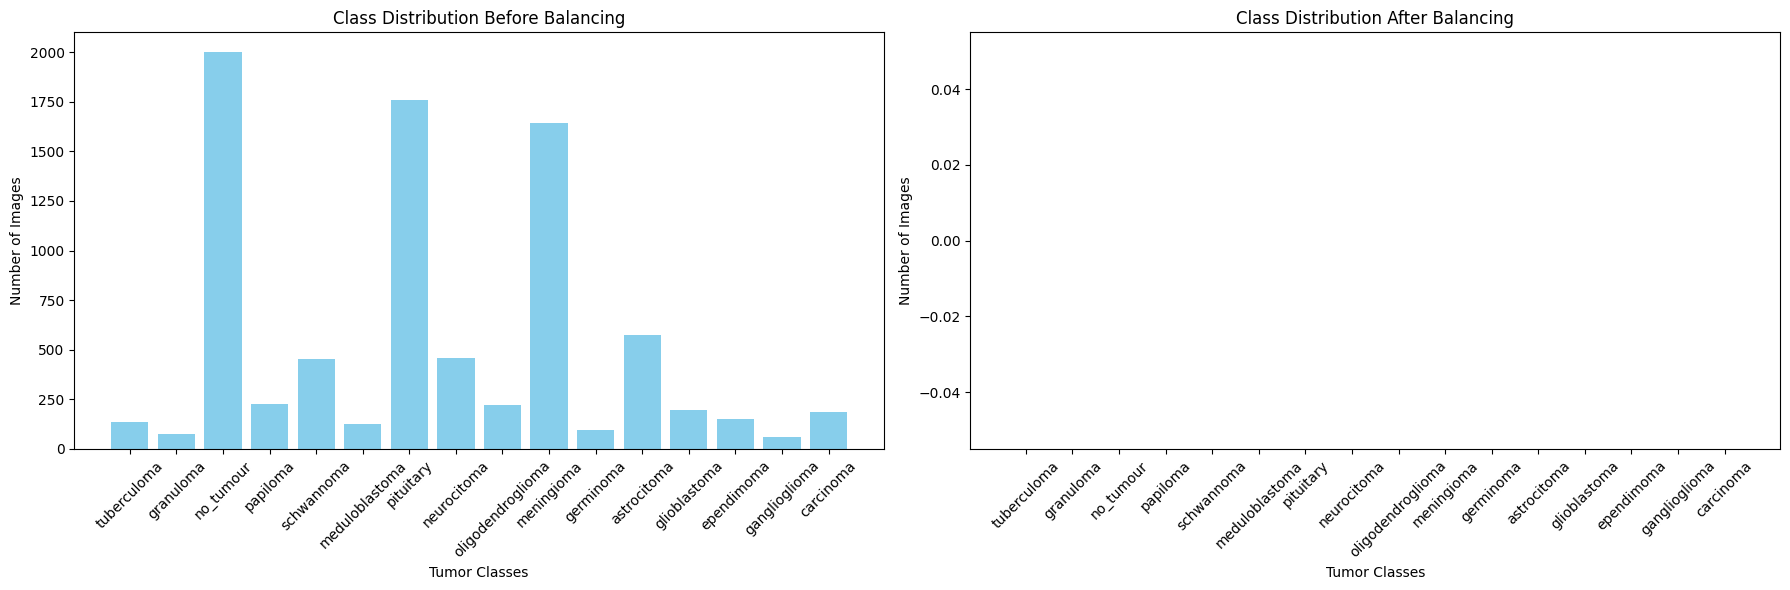

 Visualization complete.


In [29]:
def count_images_per_class(base_path):
    """Count images per tumor class."""
    class_counts = {}
    for tumor_class in tumor_classes:
        class_path = os.path.join(base_path, tumor_class)
        num_images = len([img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[tumor_class] = num_images
    return class_counts


def plot_class_distributions(before_counts, after_counts):
    """Plot side-by-side bar charts of class distributions before and after balancing."""
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Before Balancing
    axes[0].bar(before_counts.keys(), before_counts.values(), color='skyblue')
    axes[0].set_title("Class Distribution Before Balancing")
    axes[0].set_ylabel("Number of Images")
    axes[0].set_xlabel("Tumor Classes")
    axes[0].tick_params(axis='x', rotation=45)

    # After Balancing
    axes[1].bar(after_counts.keys(), after_counts.values(), color='salmon')
    axes[1].set_title("Class Distribution After Balancing")
    axes[1].set_ylabel("Number of Images")
    axes[1].set_xlabel("Tumor Classes")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def visualize_distribution():
    """Visualize class distribution before and after balancing."""
    before_counts = count_images_per_class(RAW_DATASET_PATH)
    after_counts = count_images_per_class(os.path.join(OUTPUT_PATH, "Train/Images"))

    plot_class_distributions(before_counts, after_counts)
    print(" Visualization complete.")

#  Run visualization after processing
visualize_distribution()

Main Function

Streaming output truncated to the last 5000 lines.
Augmented image saved: /content/drive/MyDrive/DSGP/CNN_Dataset/Train/Images/ependimoma/ependimoma_aug_577ad3c8-0f7a-4ddd-86ca-1f2ea76154b7.png
Augmented image saved: /content/drive/MyDrive/DSGP/CNN_Dataset/Train/Images/ependimoma/ependimoma_aug_f7480290-cb68-4d16-8d20-853fae7ee6fe.png
Augmented image saved: /content/drive/MyDrive/DSGP/CNN_Dataset/Train/Images/ependimoma/ependimoma_aug_c89edeb1-2639-4ab4-8c9f-7f8f616b0e33.png
Augmented image saved: /content/drive/MyDrive/DSGP/CNN_Dataset/Train/Images/ependimoma/ependimoma_aug_3520320f-42cc-436a-8106-bf72d9bfe878.png
Augmented image saved: /content/drive/MyDrive/DSGP/CNN_Dataset/Train/Images/ependimoma/ependimoma_aug_9485a611-795d-4d3e-8a60-fdb4c988bbf8.png
Augmented image saved: /content/drive/MyDrive/DSGP/CNN_Dataset/Train/Images/ependimoma/ependimoma_aug_3adbc907-a2dc-4875-882a-a91e1b075a1a.png
Augmented image saved: /content/drive/MyDrive/DSGP/CNN_Dataset/Train/Images/ependimoma/epen

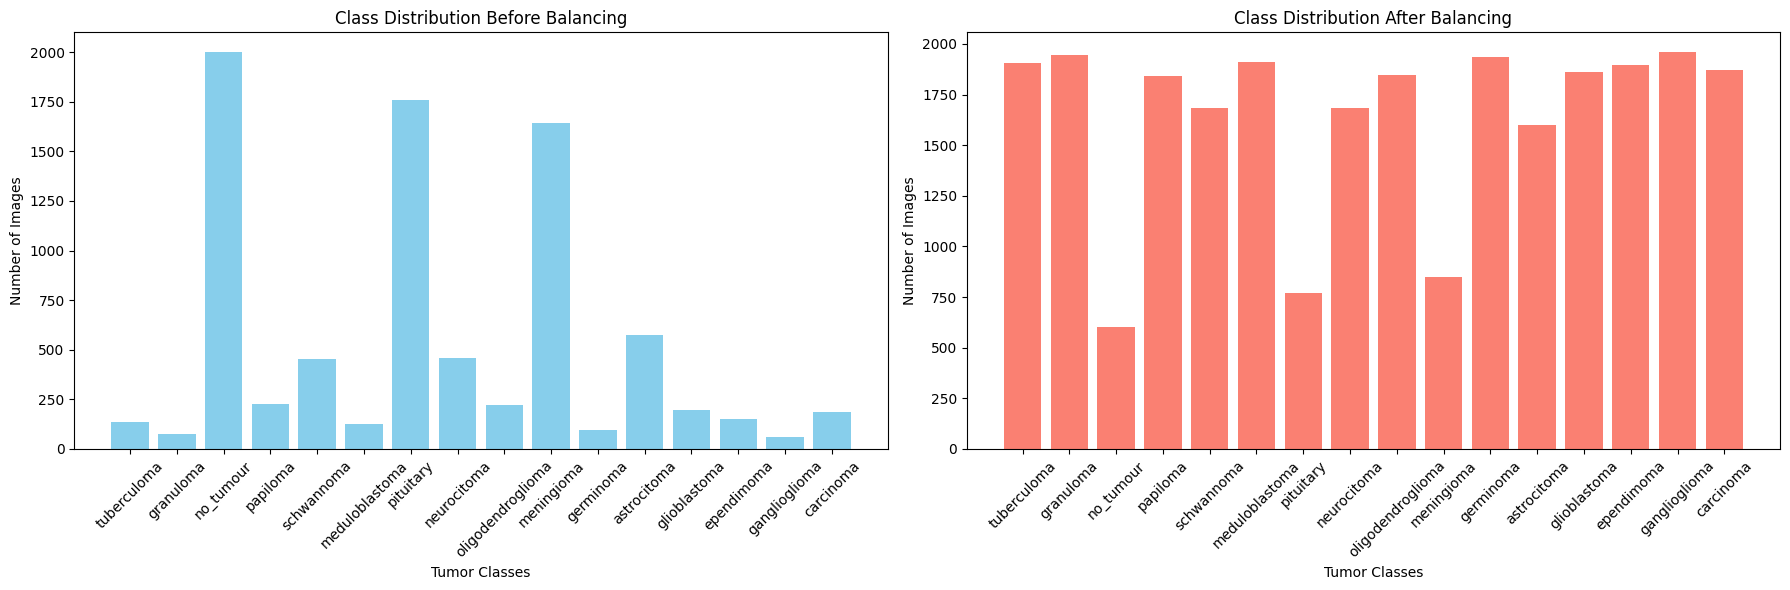

Dataset preprocessing complete and saved at: /content/drive/MyDrive/DSGP/CNN_Dataset


In [30]:
def main_pipeline():
    print("Starting preprocessing pipeline...")

    # Count classes before balancing
    before_balancing_counts = count_images_per_class(RAW_DATASET_PATH)
    print("Class counts before balancing:", before_balancing_counts)

    # Process dataset with U-Net & Balancing
    process_dataset()

    # Count classes after balancing
    after_balancing_counts = count_images_per_class(os.path.join(OUTPUT_PATH, "Train/Images"))
    print("Class counts after balancing:", after_balancing_counts)

    # Plot class distribution comparison
    plot_class_distributions(before_balancing_counts, after_balancing_counts)

    print("Dataset preprocessing complete and saved at:", OUTPUT_PATH)


# Execute the final pipeline
main_pipeline()

Visualize Tumor with Bounding Box

In [31]:
def visualize_tumor_with_bbox(image_path):
    """Visualize segmented tumor with bounding box."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
    mask = get_segmentation_mask(image)
    bbox = mask_to_bbox(mask)
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
    plt.imshow(image)
    plt.title("Tumor Segmentation with Bounding Box")
    plt.axis('off')
    plt.show()

visualize_tumor_with_bbox()

TypeError: visualize_tumor_with_bbox() missing 1 required positional argument: 'image_path'